### Importance sampling chatGPT

In [ ]:
import numpy as np
n=5000000

# True probability distribution p(x) (fair die)
p = {x: 1/n for x in range(1, n+1)}

# Biased sampling distribution q(x) (importance sampling)
q = {n: 0.5}  # More likely to sample nr. n
for x in range(1, n):
    q[x] = 0.5/(n-1)  # Less likely to sample other numbers

# Importance weights w(x) = p(x) / q(x)
w = {x: p[x] / q[x] for x in range(1, n+1)}

# Monte Carlo Sampling (Direct from p(x))
def monte_carlo(num_samples=1000):
    samples = np.random.choice(list(p.keys()), size=num_samples, p=list(p.values()))
    estimated_prob = np.mean(samples == n)  # Fraction of 6s in samples
    return estimated_prob

# Importance Sampling (Sampling from q(x) and correcting with weights)
def importance_sampling(num_samples=1000):
    samples = np.random.choice(list(q.keys()), size=num_samples, p=list(q.values()))
    weights = np.array([w[x] for x in samples])  # Apply importance weights
    estimated_prob = np.mean((samples == n) * weights)  # Weighted mean
    return estimated_prob

# Run simulations
num_samples = 100
mc_estimate = monte_carlo(num_samples)
is_estimate = importance_sampling(num_samples)

# Output results
(mc_estimate, is_estimate, 1/n)


## PINN - harmonic oscillator 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random

**True Function**  
The differential equation governing the damped harmonic oscillator is:

$m \frac{d^2 y}{d t^2} + \mu \frac{d y}{d t} + k y = 0$

**Initial Conditions:**  
- $y(0) = 1$  
- $\frac{dy}{dt}(0) = 0$  

**Parameters:**  
- $m$ = Mass  
- $\mu$ = Damping coefficient  
- $k$ = Spring constant  

---

**Exact Solution:**  
The exact solution to the differential equation is:

$y(t) = e^{-\frac{\mu t}{2 m}} \left[ A \cos(\omega t) + B \sin(\omega t) \right]$

**Where:**  
- $\omega = \sqrt{\frac{k}{m} - \left( \frac{\mu}{2 m} \right)^2}$ is the damped natural frequency.  
- $A = y_0$ (from the initial condition $y(0) = y_0$)  
- $B = \frac{\mu}{2 m \omega}$ (from the initial condition $\frac{dy}{dt}(0) = 0$)  


### Exact sol

-0.6963581621466394


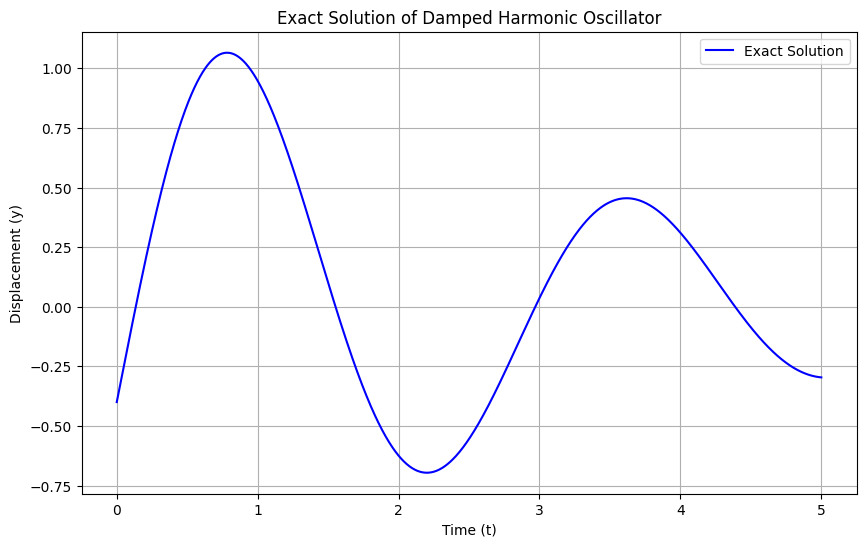

In [9]:
def damped_harmonic_oscillator(t, m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    # Check underdamped condition
    if mu**2 >= 4 * m * k:
        raise ValueError("The system is not underdamped. Ensure that μ^2 < 4 * m * k.")
    
    # Angular frequency
    omega = np.sqrt(k/m - (mu/(2*m)) ** 2)
    
    # Exact solution
    A = y0
    B = (v0 + (mu/(2*m)) * y0) / omega
    y_exact = np.exp(-mu * t / (2 * m)) * (A * np.cos(omega * t) + B * np.sin(omega * t))
    
    return y_exact

def exact_test(m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    # Time range
    t = np.linspace(0, 5, 1000)

    # Compute the exact solution
    y_exact = damped_harmonic_oscillator (t, m, mu, k, y0, v0 )
    print(min(y_exact))

    # Plotting the exact solution
    plt.figure(figsize=(10, 6))
    plt.plot(t, y_exact, label='Exact Solution', color='blue')
    plt.title('Exact Solution of Damped Harmonic Oscillator')
    plt.xlabel('Time (t)')
    plt.ylabel('Displacement (y)')
    plt.grid(True)
    plt.legend()
    plt.show()

exact_test(m=1)

### MC of exact sol with gaussian params

In [ ]:
def MC_sim(Num,m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):

    # Uncertainty in input parameters
    m_samples = np.random.normal(m, 0.1, Num)
    mu_samples = np.random.normal(mu, 0.05, Num)
    k_samples = np.random.normal(k, 0.2, Num)
    y0_samples = np.random.normal(y0, 0.0, Num)

    # Monte Carlo simulation for the damped harmonic oscillator
    y_mc = []
    for i in range(Num):
        y_mc.append(damped_harmonic_oscillator(t, m_samples[i], mu_samples[i], k_samples[i], y0_samples[i], v0))
    
    return y_mc

def plot_MC(y_mc):
    y_exact=damped_harmonic_oscillator(t)

    # probability distribution of the displacement at each time step
    y_mc = np.array(y_mc)
    y_mean = np.mean(y_mc, axis=0)
    y_std = np.std(y_mc, axis=0)

    #plotting the mean and standard deviation of the Monte Carlo simulation
    plt.figure(figsize=(10, 6))
    plt.plot(t, y_exact, label='Exact Solution', color='red')
    plt.plot(t, y_mean, label='Mean', color='blue')
    # 3 Standard Deviations
    plt.fill_between(t, y_mean - 3 * y_std, y_mean + 3 * y_std, color='blue', alpha=0.1, label='3 Standard Deviations')
    # 2 Standard Deviations
    plt.fill_between(t, y_mean - 2 * y_std, y_mean + 2 * y_std, color='blue', alpha=0.2, label='2 Standard Deviations')
    # 1 Standard Deviation
    plt.fill_between(t, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.3, label='1 Standard Deviation')
    plt.title('Monte Carlo Simulation of Damped Harmonic Oscillator')
    plt.xlabel('Time (t)')
    plt.ylabel('Displacement (y)')
    plt.grid(True)
    plt.legend()
    plt.show()

def treshold_MC(y_mc, y_threshold=-1.0):
    y_threshold= np.array(y_threshold)
    # Estimate the probability of exceeding the threshold using Importance Sampling
    prob_exceed = np.mean(np.any(y_mc < y_threshold, axis=1))
    print(f"Estimated Probability of Exceeding Threshold: {prob_exceed}")

    return prob_exceed

Num = 1000000
t = np.linspace(2, 3, 30)
y_mc = MC_sim(Num,m=1.0)
treshold_MC(y_mc, y_threshold=-0.696)
plot_MC(y_mc)


In [ ]:
plt.figure(figsize=(10, 6))
for i in range(9000,9010):
    plt.plot(t, y_mc[i], label=f'Sample {i+1}')

# Find an entry that has a value lower than -1
for i in range(Num):
    if np.any(y_mc[i] < -1):
        plt.plot(t, y_mc[i], label=f'Entry with value < -1', color='red')

plt.title('First 10 Entries of Monte Carlo Simulation and Entry with Value < -1')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

Estimated Probability of Exceeding Threshold of -1.0: 1.05e-05 (10.000.000 samples)
1.11e-05 for second run 

In [ ]:
y_mc_array = np.array(y_mc)
plt.hist(y_mc_array[:, 10], bins=50, density=True, alpha=0.6, color='g')
plt.title('Histogram of Displacement at Final Time Step')
plt.xlabel('Displacement')
plt.ylabel('Probability Density')
plt.show()

In [ ]:
import scipy.stats as stats
stats.probplot(y_mc_array[:, 20], dist="norm", plot=plt)
plt.title('Q-Q Plot of Displacement at Final Time Step')
plt.show()

### PINN functions

In [3]:
# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define the PINN model
class PINN_fixed(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3, dropout_rate=0.05):
        super(PINN_fixed, self).__init__()
        input_dim = 6
        layers = [nn.Linear(input_dim, hidden_size), nn.Tanh()]
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, m, mu, k, y0, v0):
        N = t.shape[0]
        m_  = m.expand(N, -1)
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m_, mu_, k_, y0_, v0_], dim=1)
        return self.net(x)


# Compute PDE loss
def pde_loss(model, t, m, mu, k, y0_val, v0_val):
    y = model(t, m, mu, k, y0_val, v0_val)
    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_tt = torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t), create_graph=True)[0]
    residual = m * y_tt + mu * y_t + k * y
    return torch.mean(residual**2)

# Compute boundary loss
def boundary_loss(model, t0, m, mu, k, y0, v0):
    y_pred = model(t0, m, mu, k, y0, v0)
    y_t = torch.autograd.grad(y_pred, t0, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return torch.mean((y_pred - y0)**2 + (y_t - v0)**2)

def plot_loss(epoch, losses_dict):
    plt.figure(figsize=(5, 3))
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epoch, loss_values, label=loss_name)
    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Trainer class to manage training process
class Trainer:
    def __init__(self, model, optimizer, epochs=4001):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.losses = {"Residual Loss": [], "Boundary Loss": []}
        self.lambda_bc = 10.0
    
    def train(self, t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0):
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            loss_pde = pde_loss(self.model, t_coll, m_val, mu_val, k_val, y0_val, v0_val)
            loss_bc = boundary_loss(self.model, t0, m_val, mu_val, k_val, y0_val, v0_val)
            loss = loss_pde + self.lambda_bc * loss_bc
            loss.backward()
            self.optimizer.step()
            
            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Boundary Loss"].append(loss_bc.item())
            
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}")
                plot_loss(range(epoch + 1), self.losses)

### PINN solving the PDE with fixed params

$m \frac{d^2 y}{d t^2} + \mu \frac{d y}{d t} + k y = 0$

In [ ]:
def initialize_fixed_parameters(Num=500):
    t_coll = torch.rand(Num,1)*5
    t_coll.requires_grad_(True)
    
    m, mu, k = 1.0, 0.6, 5.0
    y0, v0 = -0.4, 3.0
    
    m_val  = torch.tensor([[m]], requires_grad=True)
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val  = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)
    
    t0 = torch.tensor([0.0]).view(-1,1).requires_grad_(True)
    
    return t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0

# Run training pipeline
set_seed()
t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0 = initialize_fixed_parameters()
fixed_model = PINN_fixed(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(fixed_model.parameters(), lr=0.01)
trainer = Trainer(fixed_model, optimizer)
trainer.train(t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0)

In [ ]:
fixed_model.train()

# plot the model prediction
t_test = torch.linspace(0, 5, 1000).view(-1, 1)
y_pred = fixed_model(t_test, m_val, mu_val, k_val, y0_val, v0_val)
y_exact = damped_harmonic_oscillator(t_test)

plt.figure(figsize=(10, 6))
plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), label='PINN Prediction', color='blue')
plt.plot(t_test.detach().numpy(), y_exact, label='Exact Solution', color='red')
plt.title('PINN Prediction vs Exact Solution')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

### Simple PINN with gaussian mass

Epoch 0, PDE loss: 0.05519729480147362, BC loss: 9.271295547485352


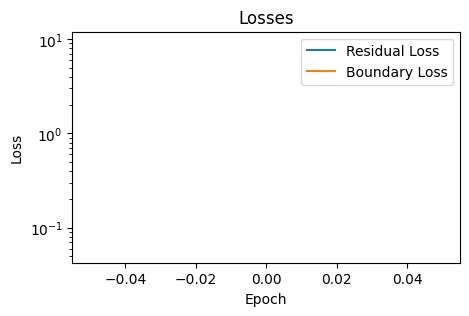

Epoch 1000, PDE loss: 0.26152122020721436, BC loss: 0.0020833145827054977


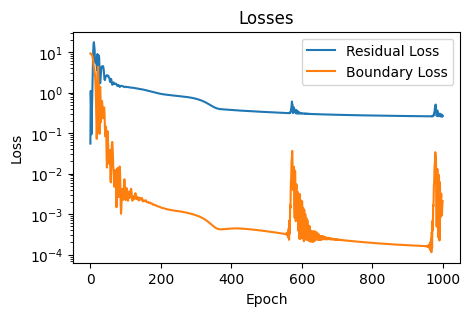

Epoch 2000, PDE loss: 0.04210056737065315, BC loss: 4.328801151132211e-05


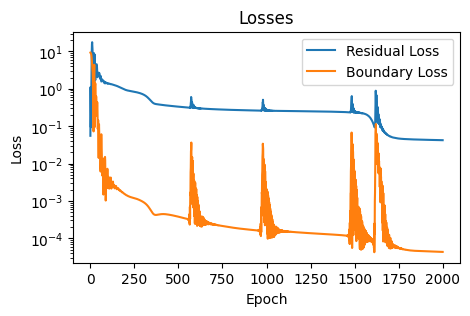

Epoch 3000, PDE loss: 0.034912578761577606, BC loss: 4.1290128137916327e-05


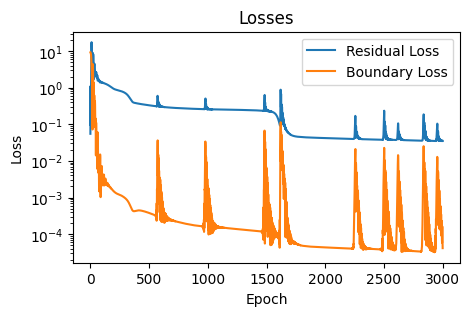

Epoch 4000, PDE loss: 0.02883204072713852, BC loss: 2.7604966817307286e-05


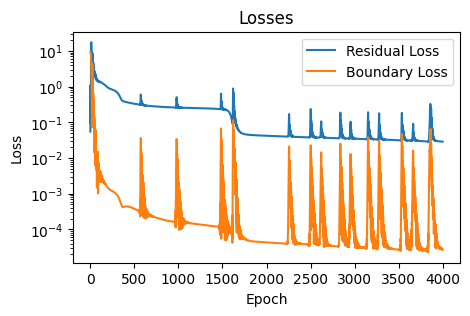

In [7]:
# Define the PINN model
class PINN_gaussian_mass(PINN_fixed):  
    def forward(self, t, m, mu, k, y0, v0):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m, mu_, k_, y0_, v0_], dim=1)
        return self.net(x)

# Initialize training parameters
def initialize_gaussian_mass():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    m_coll = m_mean + m_std * torch.randn((N, 1)) # Sample from standard normal and scale
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu, k, y0, v0 = 0.6, 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0

# Run training pipeline
set_seed()
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_gaussian_mass()
gaussian_mass_model = PINN_gaussian_mass(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(gaussian_mass_model.parameters(), lr=0.01)
trainer = Trainer(gaussian_mass_model, optimizer)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)


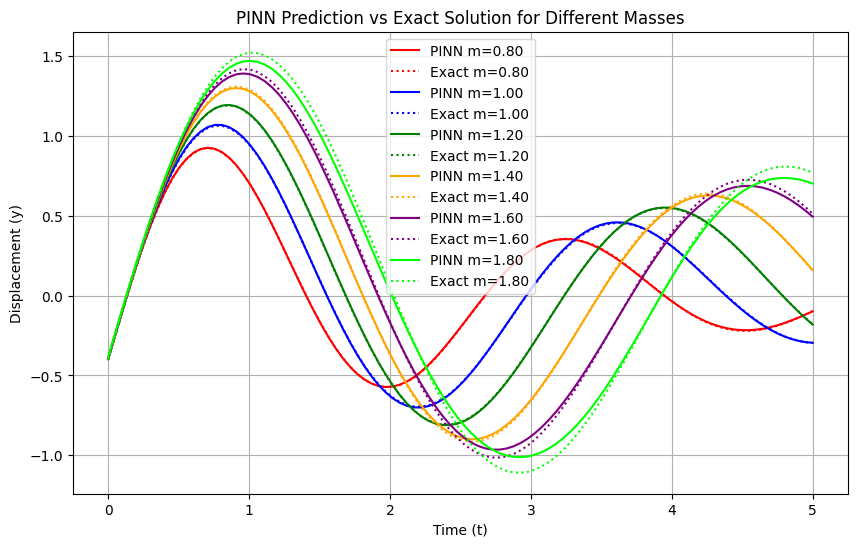

In [29]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = gaussian_mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

### Uniform distr. mass

Epoch 0, PDE loss: 0.10292552411556244, BC loss: 9.1110258102417


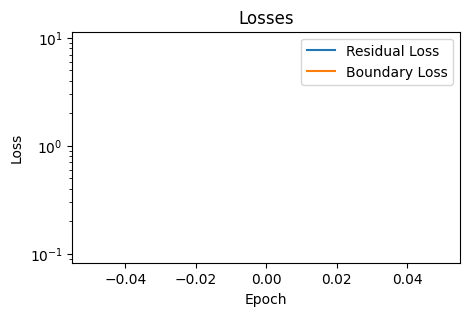

Epoch 1000, PDE loss: 0.3093051612377167, BC loss: 0.0005856184288859367


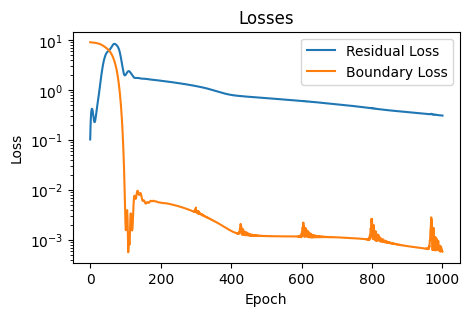

Epoch 2000, PDE loss: 0.02403653785586357, BC loss: 5.8779387472895905e-05


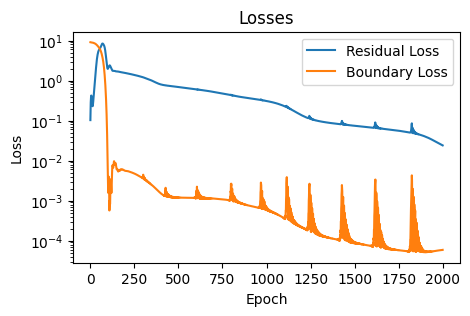

Epoch 3000, PDE loss: 0.004856558050960302, BC loss: 4.3616717448458076e-05


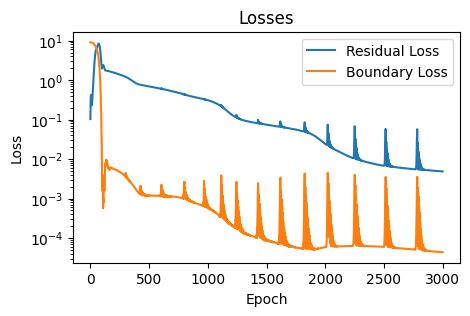

Epoch 4000, PDE loss: 0.0033431281335651875, BC loss: 2.9443815947161056e-05


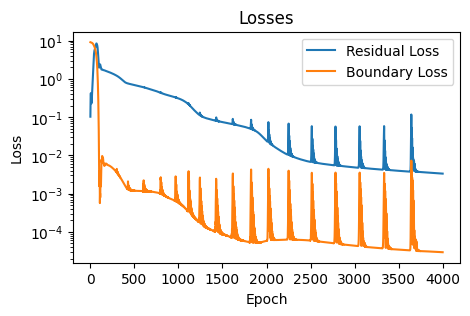

In [26]:
# Initialize training parameters
def initialize_gaussian_mass():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 4 * m_std, m_mean + 4 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu, k, y0, v0 = 0.6, 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0

# Run training pipeline
set_seed()
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_gaussian_mass()
uniform_mass_model = PINN_gaussian_mass(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(uniform_mass_model.parameters(), lr=0.001)
trainer = Trainer(uniform_mass_model, optimizer)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)

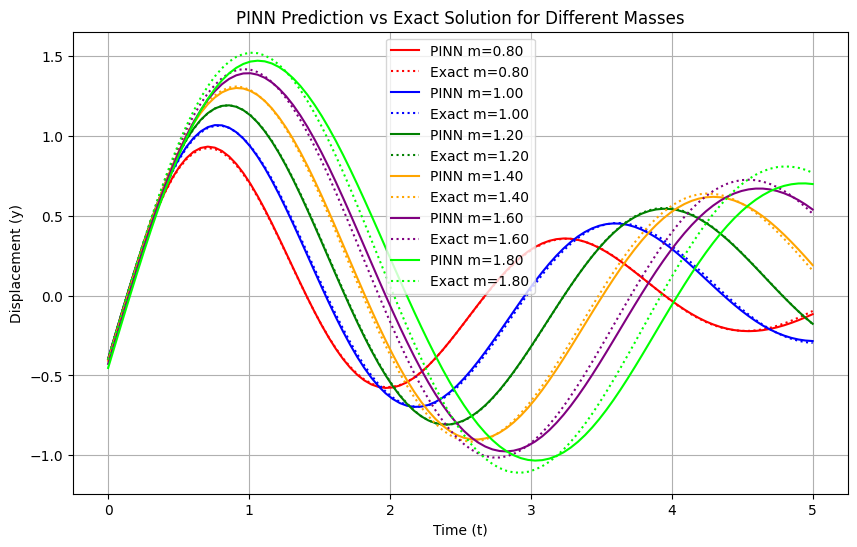

In [28]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = uniform_mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()

### Parameterized PINN with mass 

Epoch 0, PDE loss: 0.0003638958733063191, BC loss: 9.159470558166504


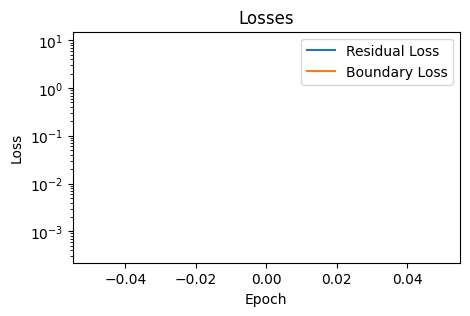

Epoch 1000, PDE loss: 0.4002267122268677, BC loss: 0.00042459595715627074


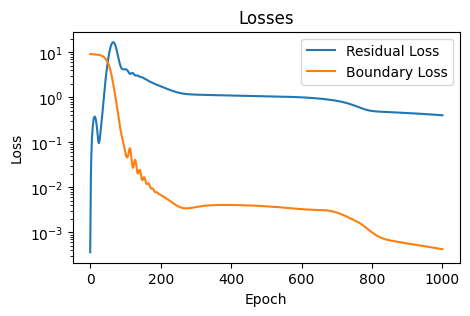

Epoch 2000, PDE loss: 0.10878460854291916, BC loss: 0.0004636959347408265


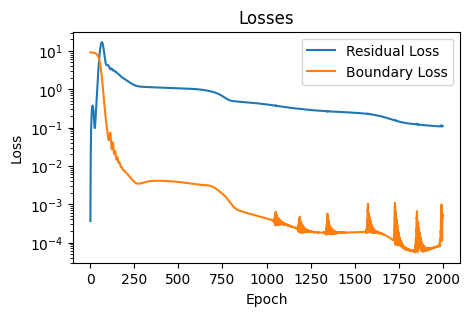

Epoch 3000, PDE loss: 0.05925937369465828, BC loss: 0.001239403267391026


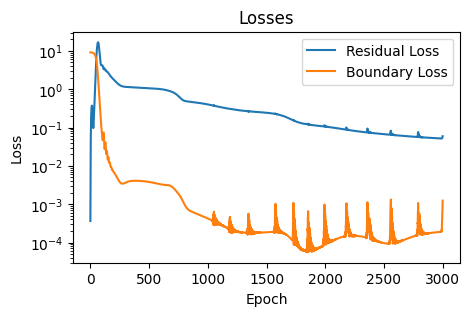

Epoch 4000, PDE loss: 0.024112898856401443, BC loss: 5.9215766668785363e-05


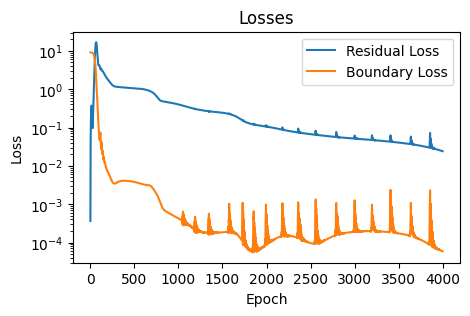

In [30]:
# Define separate encoders
class ParameterEncoder(nn.Module):
    def __init__(self, hidden_size):
        super(ParameterEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )

    def forward(self, m, mu, k):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        x = torch.cat([m, mu_, k_], dim=1)
        return self.net(x)

class CoordinateEncoder(nn.Module):
    def __init__(self, hidden_size):
        super(CoordinateEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )

    def forward(self, t, y0, v0):
        N = t.shape[0]
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, y0_, v0_], dim=1)
        return self.net(x)

# Define the main manifold network
class PINN_P2INN(nn.Module):
    def __init__(self, hidden_size=30, hidden_layers=3):
        super(PINN_P2INN, self).__init__()

        self.encoder_p = ParameterEncoder(hidden_size)
        self.encoder_c = CoordinateEncoder(hidden_size)

        layers = [nn.Linear(2 * hidden_size, hidden_size), nn.Tanh()]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, t, m, mu, k, y0, v0):
        h_param = self.encoder_p(m, mu, k)
        h_coord = self.encoder_c(t, y0, v0)
        h_concat = torch.cat([h_param, h_coord], dim=1)
        return self.net(h_concat)

# Run training pipeline
torch.manual_seed(42)
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_gaussian_mass()

P2INN_gaussian_mass_model = PINN_P2INN(hidden_size=15, hidden_layers=2)
optimizer = optim.Adam(P2INN_gaussian_mass_model.parameters(), lr=0.001)
trainer = Trainer(P2INN_gaussian_mass_model, optimizer, epochs=4001)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)


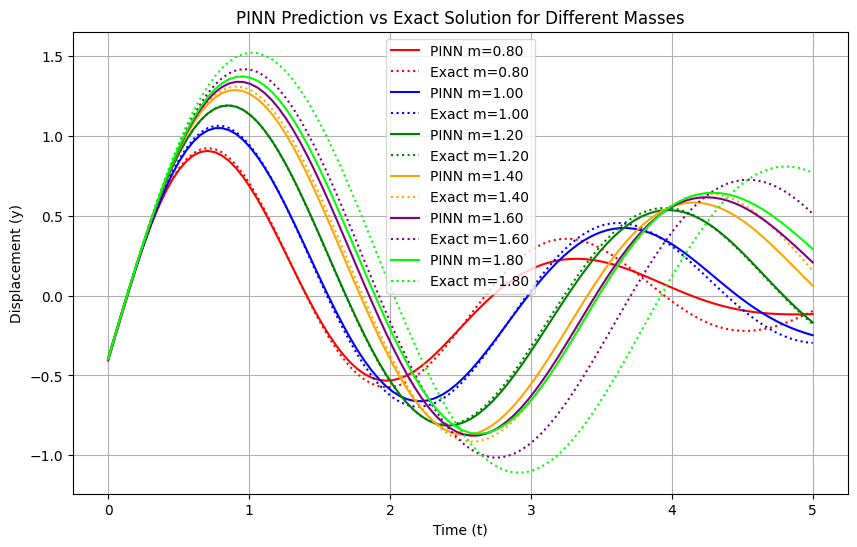

In [31]:
m_mean, m_std = 1.0, 0.1
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']

plt.figure(figsize=(10, 6))

for idx, m in enumerate(m_values):
    color = colors[idx]
    m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
    y_pred = P2INN_gaussian_mass_model(t_test, m_test, mu_val, k_val, y0_val, v0_val)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m)
    
    plt.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
    plt.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')

plt.title('PINN Prediction vs Exact Solution for Different Masses')
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.grid(True)
plt.legend()
plt.show()